# Using PyTorch + Autograd to illustrate nonlinear multi-output regression

This notebook illustrates how to perform multi-output regression using `PyTorch`.  In particular it illustrates how to 

- construct an arbitrary fully connected network / multilayer perceptron with the proper input / output dimensions

- run an RMSprop optimizer to tune paramters correctly

- how to plot a cost function history plot to ensure that optimization is running smoothly


Two datasets with input dimension / output dimension 2 are used in the illustration.

In [1]:
# import gridworld library - make sure this is executed prior to running any gridworld cell
import sys
sys.path.append('../')
import autograd.numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Utility functions for plotting

In [2]:
 def plot_data(x,y):
    # construct panels
    fig = plt.figure(figsize = (9,4))
    ax0 = plt.subplot(121,projection='3d')
    ax0.view_init(25,45)
    ax0.axis('off')

    ax1 = plt.subplot(122,projection='3d')
    ax1.view_init(25,45)
    ax1.axis('off')

    # scatter plot data in each panel
    ax0.scatter(x[0,:],x[1,:],y[0,:],c='k',edgecolor = 'w',linewidth = 1,s=60)
    ax1.scatter(x[0,:],x[1,:],y[1,:],c='k',edgecolor = 'w',linewidth = 1,s=60)
    plt.show()

In [3]:
def plot_regressions(x,y,model):
    # import all the requisite libs
    # construct panels
    fig = plt.figure(figsize = (9,4))
    ax0 = plt.subplot(121,projection='3d')
    ax0.view_init(25,45)
    ax0.axis('off')

    ax1 = plt.subplot(122,projection='3d')
    ax1.view_init(25,45)
    ax1.axis('off')

    # scatter plot data in each panel
    ax0.scatter(x[0,:],x[1,:],y[0,:],c='k',edgecolor = 'w',linewidth = 1,s=60)
    ax1.scatter(x[0,:],x[1,:],y[1,:],c='k',edgecolor = 'w',linewidth = 1,s=60)

    # construct input for each model fit
    a_ = np.linspace(0,1,10)
    a,b = np.meshgrid(a_,a_)
    a = a.flatten()[np.newaxis,:]
    b = b.flatten()[np.newaxis,:]
    c = np.vstack((a,b))

    # convert to tensor
    c = torch.from_numpy(c)
    
    # evaluate model     
    p = model.forward(c.t().float()).t().detach().numpy()    
    m1 = p[0,:]
    m2 = p[1,:]

    # plot each as surface
    a.shape = (a_.size,a_.size)
    b.shape = (a_.size,a_.size)
    m1.shape = (a_.size,a_.size)
    m2.shape = (a_.size,a_.size)

    ax0.plot_surface(a,b,m1,alpha = 0.1,color = 'lime',cstride = 2,rstride = 2,linewidth = 1,edgecolor ='k')
    ax1.plot_surface(a,b,m2,alpha = 0.1,color = 'lime',cstride = 2,rstride = 2,linewidth = 1,edgecolor ='k')

    plt.show()

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

#### compare cost function histories ####
def plot_cost_history(cost_history,start):        
    # initialize figure
    fig = plt.figure(figsize = (10,3))

    # create subplot with 1 panel
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0]); 

    # plot train cost function history
    ax.plot(np.arange(start,len(cost_history),1),cost_history[start:],linewidth = 3*(0.8)**(1),label = 'train cost') 

    # clean up panel / axes labels
    xlabel = 'step $k$'
    ylabel = r'$g\left(\mathbf{w}^k\right)$'
    ax.set_xlabel(xlabel,fontsize = 14)
    ax.set_ylabel(ylabel,fontsize = 14,rotation = 0,labelpad = 25)
    title = 'train histories'
    ax.set_title(title,fontsize = 18)

    # plot legend
    anchor = (1,1)
    plt.legend(loc='upper right', bbox_to_anchor=anchor)
    ax.set_xlim([start - 0.5,len(cost_history) - 0.5]) 
    plt.show()

# Example multi-output datasets

<IPython.core.display.Javascript object>


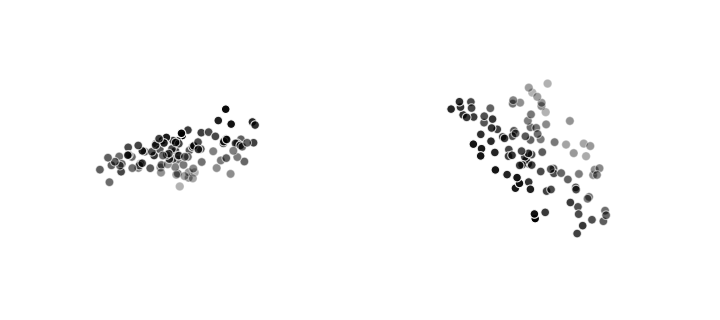

In [5]:
# load in data
csvname = '../datasets/linear_2output_regression.csv'
linear_data = np.loadtxt(csvname,delimiter=',')
x_lin = linear_data[:2,:]
y_lin = linear_data[2:,:]

# plot
plot_data(x_lin,y_lin)

<IPython.core.display.Javascript object>


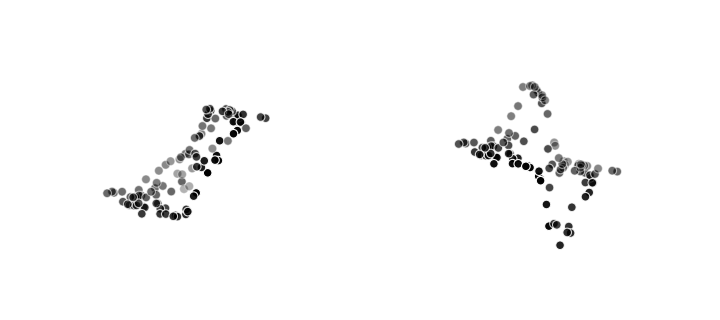

In [6]:
# load in data
csvname = '../datasets/nonlinear_2output_regression.csv'
nonlinear_data = np.loadtxt(csvname,delimiter=',')
x_nonlin = nonlinear_data[:2,:]
y_nonlin = nonlinear_data[2:,:]

# plot
plot_data(x_nonlin,y_nonlin)

# Setup network architecture

In [7]:
'''
PyTorch does not the same abstract API Keras does for optimization, in particular
while it does contain an array of advanced first order methods like e.g., RMSprop
one needs to construct one's own looping structure in order to employ it properly. 
Below the class My_Opt does just this.  
'''
class My_Opt:
    def __init__(self,model,cost):
        self.model = model
        self.cost = cost
        learning_rate = 10**(-2)
        self.optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        
        # record history
        self.cost_history = []
        self.weight_history = []
        
    def fit(self,x,y,max_its,lr):
        # update learning rate
        self.optimizer.param_groups[0]['lr'] = lr
        
        for t in range(max_its):
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = self.model(x.float())

            # Compute and print loss.
            cost_val = self.cost(y_pred, y.float())
            self.optimizer.zero_grad()

            if len(self.cost_history) == 0 or t > 0:
                # store weight and cost history
                self.cost_history.append(cost_val.data.item())
                self.weight_history.append(self.optimizer.param_groups[0]['params'])

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            cost_val.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            self.optimizer.step()

        # collect last input / weights
        y_pred = self.model(x.float())
        cost_val = self.cost(y_pred, y.float())
        self.cost_history.append(cost_val.data.item())
        self.weight_history.append(self.optimizer.param_groups[0]['params'])

In [8]:
# -*- coding: utf-8 -*-
import torch

'''
A generic function for building network architectures for multi-output regression.
Input/output data is used to size the input / output layers of the network.  All other 
parameters - e.g., num layers, layer sizes, optimizer, learning rate have default settings
or can be changed by user.
'''

def build_model(x,y,**kwargs):
    # default parameters for network
    layer_sizes = [10,10]      # two hidden layers, 10 units each, by default
    activation = 'relu'
    if 'layer_sizes' in kwargs:
        layer_sizes = kwargs['layer_sizes']
    if 'activation' in kwargs:
        activation = kwargs['activation']    
    
    # input / output sizes of network
    input_dim = x.shape[0]
    output_dim = y.shape[0]       
    
    # Use the nn package to define our model and loss function
    model = torch.nn.Sequential()

    # add input layer
    model.add_module('linear ' + str(0),torch.nn.Linear(input_dim,layer_sizes[0]))
    if activation == 'relu':
        model.add_module('activation ' + str(0),torch.nn.ReLU())
    if activation == 'tanh':
        model.add_module('activation ' + str(0),torch.nn.Tanh())
                        
    # add hidden layers
    for i in range(1,len(layer_sizes)):
        U = layer_sizes[i-1]
        V = layer_sizes[i]
        model.add_module('linear ' + str(i),torch.nn.Linear(U,V))
        if activation == 'relu':
            model.add_module('activation ' + str(i),torch.nn.ReLU())
        if activation == 'tanh':
            model.add_module('activation ' + str(i),torch.nn.Tanh())

    # add output layer
    model.add_module('linear ' + str(len(layer_sizes)),torch.nn.Linear(layer_sizes[-1], output_dim))

    # define cost function
    cost = torch.nn.MSELoss(size_average=True)
    
    # setup optimizer - using hand-made optimizer class + RMSprop
    opt = My_Opt(model,cost)
    return opt

# Build and fit LINEAR multi-output regression dataset

In [9]:
from torch.autograd import Variable

# convert input numpy array to PyTorch tensor
x = Variable(torch.from_numpy(x_lin),requires_grad=False)
y = Variable(torch.from_numpy(y_lin),requires_grad=False)

# build optimizer, model, etc., 
opt = build_model(x,y,layer_sizes = [2],activation = 'linear')

# take a step
max_its = 500
lr = 10**(-2)
opt.fit(x.t(),y.t(),max_its,lr)

<IPython.core.display.Javascript object>


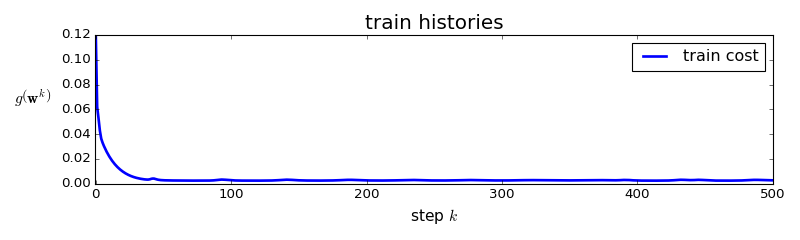

<IPython.core.display.Javascript object>


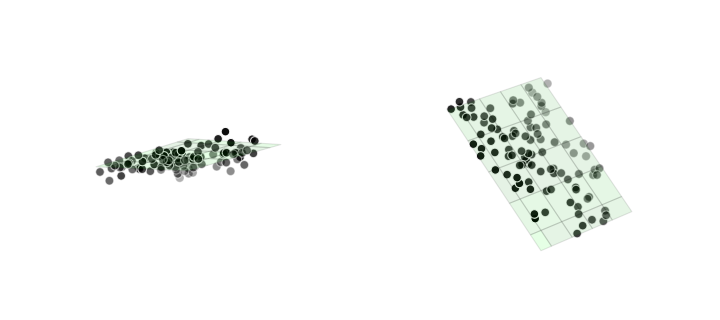

In [10]:
# build model for this dataset
plot_cost_history(opt.cost_history,start = 0)

# find best set of weights based on lowest cost val
plot_regressions(x_lin,y_lin,opt.model)

# Build and fit NONLINEAR multi-output regression dataset

In [11]:
from torch.autograd import Variable

# convert input numpy array to PyTorch tensor
x = Variable(torch.from_numpy(x_nonlin),requires_grad=False)
y = Variable(torch.from_numpy(y_nonlin),requires_grad=False)

# build optimizer, model, etc., 
opt = build_model(x,y,layer_sizes = [10,10],activation = 'tanh')

# take a step
max_its = 2000
lr = 10**(-2)
opt.fit(x.t(),y.t(),max_its,lr)

<IPython.core.display.Javascript object>


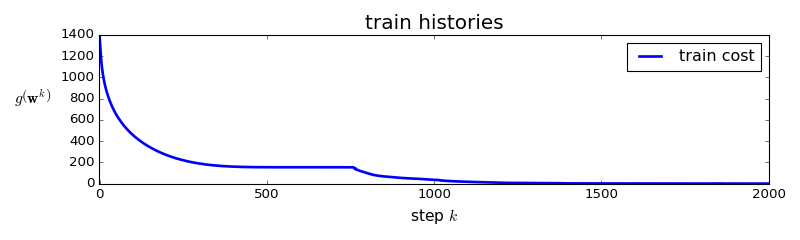

<IPython.core.display.Javascript object>


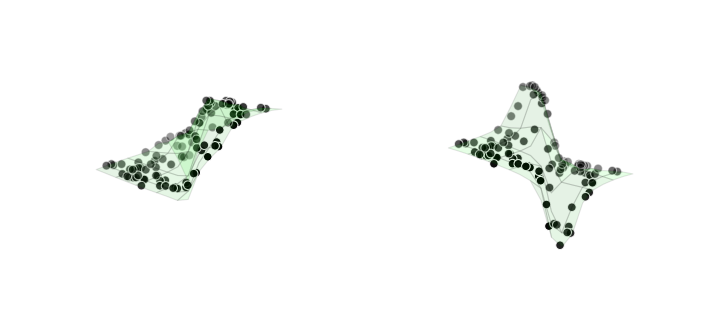

In [12]:
# build model for this dataset
plot_cost_history(opt.cost_history,start = 0)

# find best set of weights based on lowest cost val
plot_regressions(x_nonlin,y_nonlin,opt.model)